In [43]:
import numpy as np
import pandas as pd

import scipy
from statsmodels.stats.weightstats import *
from statsmodels.stats.proportion import proportion_confint

In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('credit_card_default_analysis.csv')

In [3]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


1. Размер кредитного лимита (LIMIT_BAL)


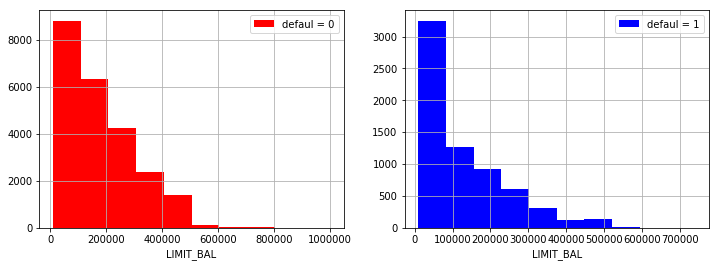

In [32]:
pylab.figure(figsize=(12,4))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(data.LIMIT_BAL[data.default==0], color = 'r')
pylab.xlabel('LIMIT_BAL')
pylab.legend(['defaul = 0'])

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(data.LIMIT_BAL[data.default==1], color = 'b')
pylab.xlabel('LIMIT_BAL')
pylab.legend(['defaul = 1'])

pylab.show()

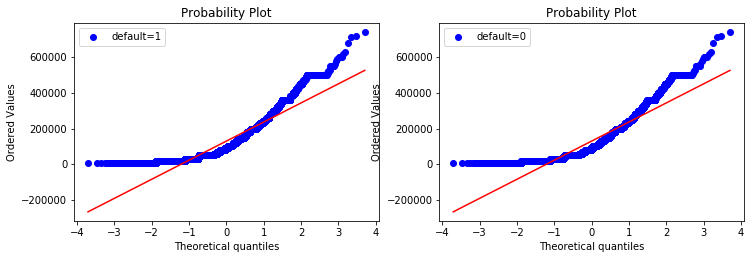

In [35]:
pylab.figure(figsize=(12,8))
pylab.subplot(2,2,1)
stats.probplot(data.LIMIT_BAL[data.default==1], dist="norm", plot=pylab)
pylab.legend(['default=1'])

pylab.subplot(2,2,2)
stats.probplot(data.LIMIT_BAL[data.default==1], dist="norm", plot=pylab)
pylab.legend(['default=0'])

In [34]:
stats.mannwhitneyu(data.LIMIT_BAL[data.default==0], data.LIMIT_BAL[data.default==1])

MannwhitneyuResult(statistic=59257217.5, pvalue=6.127742909111652e-190)

In [36]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [37]:
def get_random_combinations(n1, n2, max_combinations):
    index = range(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [38]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

In [39]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [40]:
print "p-value: %f" % permutation_test(data.LIMIT_BAL[data.default==0], data.LIMIT_BAL[data.default==1], max_permutations = 10000)

p-value: 0.000100


2.Пол (SEX)

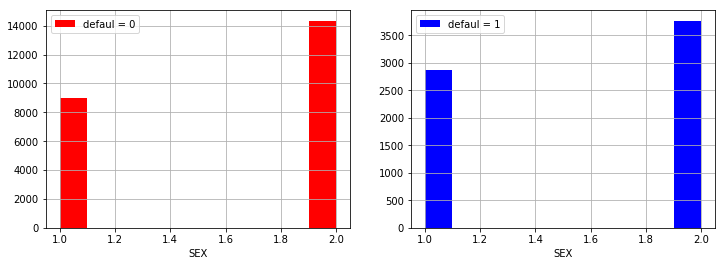

In [41]:
pylab.figure(figsize=(12,4))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(data.SEX[data.default==0], color = 'r')
pylab.xlabel('SEX')
pylab.legend(['defaul = 0'])

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(data.SEX[data.default==1], color = 'b')
pylab.xlabel('SEX')
pylab.legend(['defaul = 1'])

pylab.show()

In [76]:
z = scipy.stats.norm.ppf(1 - 0.05 / 2.)

n1 = len(data.SEX[data.SEX==1])
n2 = len(data.SEX[data.SEX==2])

p1 = float(len(data.SEX[data.default==1][data.SEX==1])) / n1
p2 = float(len(data.SEX[data.default==1][data.SEX==2])) / n2
p = (p1*n1 + p2*n2)/(n1+n2)

    
left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(data.SEX[data.SEX==1]) + p2 * (1 - p2)/ len(data.SEX[data.SEX==2]))
right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(data.SEX[data.SEX==1]) + p2 * (1 - p2)/ len(data.SEX[data.SEX==2]))

print "confidence interval: [%f, %f]" % (left_boundary, right_boundary)

confidence interval: [0.024207, 0.043612]


In [87]:
z_stat = (p1-p2)/np.sqrt(p*(1-p)*(1./n1 + 1./n2))

print 2*(1 - scipy.stats.norm.cdf(z_stat))

4.472866521609831e-12


3.Образование (EDUCATION)

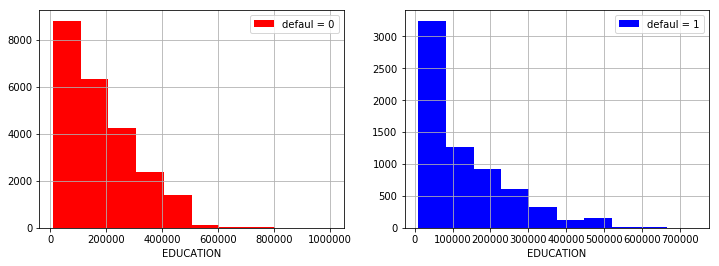

In [88]:
pylab.figure(figsize=(12,4))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(data.LIMIT_BAL[data.default==0], color = 'r')
pylab.xlabel('EDUCATION')
pylab.legend(['defaul = 0'])

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(data.LIMIT_BAL[data.default==1], color = 'b')
pylab.xlabel('EDUCATION')
pylab.legend(['defaul = 1'])

pylab.show()